In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from netCDF4 import Dataset

from FiniteDiff import FiniteDiff

## Load the Coarse-Graining Results

In [10]:
# Load coarse-graining results
full_data = { 'filename' : 'RESULTS_full.nc',      'label' : 'Full Vel.' }
tor_data  = { 'filename' : 'RESULTS_toroidal.nc',  'label' : 'Tor. Vel.' }
pot_data  = { 'filename' : 'RESULTS_potential.nc', 'label' : 'Pot. Vel.' }

for dataset in [full_data, tor_data, pot_data]:
    with Dataset( dataset['filename'], 'r' ) as dset:

        dataset['ell'] = dset['ell'][:]

        dataset['depth'] = dset['depth'][:]

        dataset['regions'] = [ reg.strip() for reg in dset['region'] ]

        dataset['cKE'] = np.squeeze(dset['coarse_KE_area_average'][Ellipsis])
        dataset['cEN'] = np.squeeze(dset['enstrophy_area_average'][Ellipsis])

### Create finite difference derivatives to get spectra

In [11]:
# Create finite difference derivatives to get spectra
ddk    = FiniteDiff(          1. / full_data['ell'],  4, Sparse = True, Uniform = False, Periodic = False )
ddlogk = FiniteDiff( np.log10(1. / full_data['ell']), 4, Sparse = True, Uniform = False, Periodic = False )

## Create and Plot Filtering Spectra

The following code block plots the globally-averaged filtering spectra of kinetic energy and enstrophy.

Feature to note:
1. Enstrophy is toroidal-only, as expected
2. Filtering spectra show potential peak at slightly smaller scales than toroidal, matching the smaller meridional scale of the potential function (see oscript that creates initial velocity fields)
3. In all spectra, there is a 'divot' near 600km. This is a resolution artefact resulting from the spacing between filter scales being smaller than the grid-scale. This 'divot' is an indicator of what scales should be considered too small to have reliable results.

/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log10
  


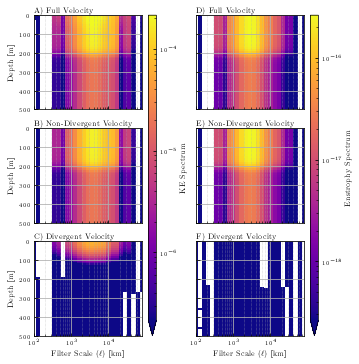

In [24]:
# Create and Plot Filtering Spectra
region = 'Global'

fig, axes = plt.subplots( 3, 2, sharex = True, sharey = True, figsize = (5,5), 
                          gridspec_kw = dict( left = 0.075, right = 0.9, bottom = 0.075, top = 0.965 ) )

for Idata, dataset in enumerate([full_data, tor_data, pot_data]):

    region_index = dataset['regions'].index(region)

    KE_spect = (ddk.dot( dataset['cKE'][:,:,region_index] )).T
    EN_spect = (ddk.dot( dataset['cEN'][:,:,region_index] )).T
    
    if Idata == 0:
        vmin_KE, vmax_KE = np.nanpercentile( np.log10( KE_spect ), [1, 99] )
        vmin_EN, vmax_EN = np.nanpercentile( np.log10( EN_spect ), [1, 99] )
    
    qm_KE = axes[Idata,0].pcolormesh( dataset['ell'] / 1e3, dataset['depth'], KE_spect, 
                             norm = colors.LogNorm( vmin = 10**(vmax_KE-3), vmax = 10**vmax_KE ), cmap = 'plasma' )
    qm_EN = axes[Idata,1].pcolormesh( dataset['ell'] / 1e3, dataset['depth'], EN_spect, 
                             norm = colors.LogNorm( vmin = 10**(vmax_EN-3), vmax = 10**vmax_EN ), cmap = 'plasma' )


for ax in axes.ravel():
    ax.set_xscale('log')
    
    ax.grid( which = 'major' )
    ax.grid( which = 'minor', linestyle = ':', linewidth = 0.5 )

    ax.set_xlim( dataset['ell'].min() / 1e3, dataset['ell'].max() / 1e3 )
    ax.set_ylim( dataset['depth'].max(), dataset['depth'].min() )

cb_KE = plt.colorbar( qm_KE, ax = axes[:,0], aspect = 40, label = 'KE Spectrum', extend = 'min' )
cb_EN = plt.colorbar( qm_EN, ax = axes[:,1], aspect = 40, label = 'Enstrophy Spectrum', extend = 'min' )

axes[0,0].set_title('A) Full Velocity',            loc = 'left', pad = 3)
axes[1,0].set_title('B) Non-Divergent Velocity',   loc = 'left', pad = 3)
axes[2,0].set_title('C) Divergent Velocity',       loc = 'left', pad = 3)

axes[0,1].set_title('D) Full Velocity',            loc = 'left', pad = 3)
axes[1,1].set_title('E) Non-Divergent Velocity',   loc = 'left', pad = 3)
axes[2,1].set_title('F) Divergent Velocity',       loc = 'left', pad = 3)

for ax in axes[-1,:]:
    ax.set_xlabel('Filter Scale ($\ell$) [km]')
    
for ax in axes[:,0]:
    ax.set_ylabel('Depth [m]')

plt.savefig('filtering_spectra.pdf')
#plt.close()